In [16]:
import pandas as pd
import numpy as np
# load libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import StratifiedGroupKFold,StratifiedShuffleSplit,KFold,train_test_split
from catboost import CatBoostRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import lightgbm as lgb
from sklearn.model_selection import KFold
import numpy as np
import lightgbm as lgb
from catboost import CatBoostRegressor
from scipy.optimize import minimize
from tqdm import tqdm
from xgboost import XGBRegressor

In [ ]:
#data
train=pd.read_csv("../dataset/train_features.csv")
y=pd.read_csv("../dataset/train_labels.csv")
test=pd.read_csv("../dataset/test_features.csv")
ss=pd.read_csv("../dataset/submission_format.csv")

In [3]:
train.head(2)

,uid,age_03,urban_03,married_03,n_mar_03,edu_gru_03,n_living_child_03,migration_03,glob_hlth_03,adl_dress_03,...,rrelgimp_12,rrfcntx_m_12,rsocact_m_12,rrelgwk_12,a16a_12,a21_12,a22_12,a33b_12,a34_12,j11_12
0,aace,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.somewhat important,9.Never,9.Never,0.No,NaN,NaN,NaN,NaN,NaN,Concrete 2
1,aanz,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.very important,9.Never,1.Almost every day,0.No,NaN,NaN,NaN,NaN,NaN,Concrete 2


In [4]:
test.head(2)

,uid,age_03,urban_03,married_03,n_mar_03,edu_gru_03,n_living_child_03,migration_03,glob_hlth_03,adl_dress_03,...,rrelgimp_12,rrfcntx_m_12,rsocact_m_12,rrelgwk_12,a16a_12,a21_12,a22_12,a33b_12,a34_12,j11_12
0,abxu,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Wood, mosaic, or other covering 1"
1,aeol,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.very important,9.Never,9.Never,1.Yes,NaN,NaN,NaN,NaN,NaN,Concrete 2


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Columns: 184 entries, uid to j11_12
dtypes: float64(140), object(44)
memory usage: 4.6+ MB


In [6]:
#let merge train and label
merged_df = pd.merge(train, y, on='uid', how='left')

In [7]:
merged_df["year"]

0       2021
1       2021
2       2016
3       2021
4       2021
        ... 
4338    2021
4339    2016
4340    2021
4341    2021
4342    2021
Name: year, Length: 4343, dtype: int64

In [8]:
#so many missing values
merged_df.isnull().sum()

uid                   0
age_03             1456
urban_03           1454
married_03         1454
n_mar_03           1482
                   ... 
a33b_12            4288
a34_12             1601
j11_12               89
year                  0
composite_score       0
Length: 186, dtype: int64

In [9]:
#lets merged test AND sample submission
merged_test = pd.merge(test, ss, on='uid', how='left')

In [10]:
merged_test["year"]

0       2016
1       2016
2       2021
3       2016
4       2021
        ... 
1100    2016
1101    2021
1102    2016
1103    2021
1104    2021
Name: year, Length: 1105, dtype: int64

<Axes: title={'center': 'Target Distribution'}, ylabel='Frequency'>

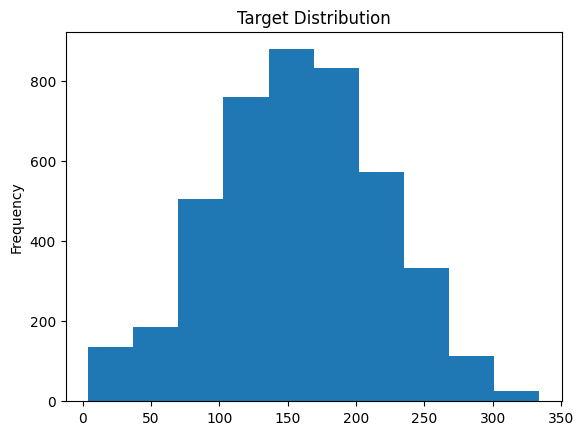

In [11]:
merged_df['composite_score'].plot(kind='hist',title='Target Distribution')

In [12]:
y=merged_df['composite_score']
data=pd.concat((merged_df,merged_test)).reset_index(drop=True).copy()
data=data.drop(columns=['uid','composite_score'],axis=1)

# Get the columns with object datatype
object_cols = data.select_dtypes(include=['object']).columns

# Convert the object columns to category dtype
for col in object_cols:
    #data[col] = data[col].astype('category').fillna("Missing")
    data[col] = pd.Categorical(data[col].fillna("Missing"))

In [13]:
#separate train and test
merged_df=data[:len(merged_df)]
merged_test=data[len(merged_df):]

In [14]:
merged_df.shape

(4343, 184)

In [18]:
# Define the number of folds
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Placeholder for storing results
fold_results = []
optimized_weights_list = []

for train_index, val_index in tqdm(kf.split(merged_df)):
    # Split the data
    train_X, val_X = merged_df.iloc[train_index], merged_df.iloc[val_index]
    train_y, val_y = y.iloc[train_index], y.iloc[val_index]

    # Train LightGBM
    model1 = lgb.LGBMRegressor( # feature_fraction=0.8, bagging_fraction=0.8,
        learning_rate=0.01, n_estimators=1000, random_state=42,
        metric='RMSE'
    )
    model1.fit(train_X, train_y, eval_set=[(val_X, val_y)])
    pred1 = model1.predict(val_X, num_iteration=model1.best_iteration_)

    # Train CatBoost
    model2 = CatBoostRegressor(
        iterations=10000, learning_rate=0.01, depth=10, loss_function='RMSE',
        cat_features=merged_df.select_dtypes(include=['object', 'category']).columns.to_list(),
        verbose=100, early_stopping_rounds=500
    )
    model2.fit(train_X, train_y, eval_set=(val_X, val_y))
    pred2 = model2.predict(val_X)
    
    # Train XGBoost
    model3 = XGBRegressor(n_estimators=10000, learning_rate=0.01,
        max_depth=3, random_state=42, 
        enable_categorical=True,
        eval_metric=root_mean_squared_error,
        early_stopping_rounds=500)
    model3.fit(train_X, train_y, eval_set=[(val_X, val_y)], verbose=100)
    pred3 = model3.predict(val_X)

    # Define loss function for weight optimization
    def loss_function(weights):
        w1, w2, w3 = weights
        combined_predictions = w1 * pred1 + w2 * pred2 + w3 * pred3
        mse = np.mean((combined_predictions - val_y) ** 2)
        return mse

    # Initial weights
    initial_weights = [1/3, 1/3, 1/3]

    # Constraints: weights must sum to 1
    constraints = {'type': 'eq', 'fun': lambda w: w[0] + w[1] + w[2] - 1}

    # Bounds: weights must be between 0 and 1
    bounds = [(0, 1), (0, 1), (0, 1)]

    # Optimize weights
    result = minimize(loss_function, initial_weights, constraints=constraints, bounds=bounds)
    optimized_weights = result.x

    # Combine predictions using optimized weights
    final_predictions = (
        optimized_weights[0] * pred1 +
        optimized_weights[1] * pred2 +
        optimized_weights[2] * pred3
    )

    # Store results
    fold_mse = root_mean_squared_error(val_y, final_predictions)  # RMSE
    fold_results.append(fold_mse)
    optimized_weights_list.append(optimized_weights)

# Display results
print(f"Average MSE across folds: {np.mean(fold_results)}")
print(f"Optimized weights per fold: {optimized_weights_list}")


0it [00:00, ?it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000915 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1565
[LightGBM] [Info] Number of data points in the train set: 3474, number of used features: 184
[LightGBM] [Info] Start training from score 157.136730
0:	learn: 61.0968399	test: 58.8058395	best: 58.8058395 (0)	total: 87.3ms	remaining: 14m 33s
100:	learn: 45.4410279	test: 45.6028066	best: 45.6028066 (100)	total: 2.34s	remaining: 3m 49s
200:	learn: 39.0878675	test: 41.5456612	best: 41.5456612 (200)	total: 4.96s	remaining: 4m 1s
300:	learn: 35.5986901	test: 39.9273411	best: 39.9273411 (300)	total: 7.92s	remaining: 4m 15s
400:	learn: 33.2094891	test: 39.1314163	best: 39.1314163 (400)	total: 10.7s	remaining: 4m 16s
500:	learn: 31.4176779	test: 38.6480547	best: 38.6480547 (500)	total: 13.3s	remaining: 4m 11s
600:	learn: 30.1218652	test: 38

1it [04:32, 272.27s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002043 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1558
[LightGBM] [Info] Number of data points in the train set: 3474, number of used features: 184
[LightGBM] [Info] Start training from score 157.271445
0:	learn: 59.9979103	test: 63.2095608	best: 63.2095608 (0)	total: 108ms	remaining: 18m 1s
100:	learn: 45.1486532	test: 47.5175717	best: 47.5175717 (100)	total: 2.58s	remaining: 4m 12s
200:	learn: 39.0906320	test: 42.2019668	best: 42.2019668 (200)	total: 5.42s	remaining: 4m 24s
300:	learn: 35.7810579	test: 40.0875359	best: 40.0875359 (300)	total: 8.28s	remaining: 4m 26s
400:	learn: 33.4582687	test: 39.0410680	best: 39.0410680 (400)	total: 11.1s	remaining: 4m 24s
500:	learn: 31.8339698	test: 38.4222289	best: 38.4222289 (500)	total: 13.9s	remaining: 4m 24s
600:	learn: 30.4534694	test: 38.

2it [07:50, 228.50s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001930 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1574
[LightGBM] [Info] Number of data points in the train set: 3474, number of used features: 184
[LightGBM] [Info] Start training from score 156.375360
0:	learn: 60.9011270	test: 59.6063548	best: 59.6063548 (0)	total: 18.9ms	remaining: 3m 9s
100:	learn: 45.0866310	test: 46.6020960	best: 46.6020960 (100)	total: 2.3s	remaining: 3m 45s
200:	learn: 38.8123756	test: 42.7566805	best: 42.7566805 (200)	total: 5.15s	remaining: 4m 11s
300:	learn: 35.1670499	test: 41.0863368	best: 41.0863368 (300)	total: 8.03s	remaining: 4m 18s
400:	learn: 32.7953003	test: 40.3183533	best: 40.3183533 (400)	total: 10.8s	remaining: 4m 18s
500:	learn: 31.0434299	test: 39.8397078	best: 39.8397078 (500)	total: 13.6s	remaining: 4m 18s
600:	learn: 29.7852070	test: 39.5

3it [11:02, 212.18s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001256 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1571
[LightGBM] [Info] Number of data points in the train set: 3475, number of used features: 184
[LightGBM] [Info] Start training from score 157.237122
0:	learn: 60.6014303	test: 60.7946485	best: 60.7946485 (0)	total: 18.6ms	remaining: 3m 6s
100:	learn: 45.1270455	test: 46.8539846	best: 46.8539846 (100)	total: 2.21s	remaining: 3m 37s
200:	learn: 38.8983723	test: 42.3812053	best: 42.3812053 (200)	total: 5.18s	remaining: 4m 12s
300:	learn: 35.4510649	test: 40.6666022	best: 40.6666022 (300)	total: 8.26s	remaining: 4m 26s
400:	learn: 33.2082143	test: 39.8262530	best: 39.8262530 (400)	total: 11.4s	remaining: 4m 32s
500:	learn: 31.5916940	test: 39.3422105	best: 39.3422105 (500)	total: 14.3s	remaining: 4m 30s
600:	learn: 30.3353372	test: 39.

4it [16:02, 246.54s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000950 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1560
[LightGBM] [Info] Number of data points in the train set: 3475, number of used features: 184
[LightGBM] [Info] Start training from score 157.063309
0:	learn: 60.6063864	test: 60.8112299	best: 60.8112299 (0)	total: 16.8ms	remaining: 2m 47s
100:	learn: 44.6720446	test: 47.5307961	best: 47.5307961 (100)	total: 2.31s	remaining: 3m 46s
200:	learn: 38.3069288	test: 43.9226278	best: 43.9226278 (200)	total: 5.01s	remaining: 4m 4s
300:	learn: 34.8000820	test: 42.5284960	best: 42.5284960 (300)	total: 7.76s	remaining: 4m 10s
400:	learn: 32.6221258	test: 41.9003158	best: 41.9003158 (400)	total: 10.4s	remaining: 4m 10s
500:	learn: 31.0140313	test: 41.4877224	best: 41.4877224 (500)	total: 13.1s	remaining: 4m 8s
600:	learn: 29.6661111	test: 41.2

5it [20:32, 246.43s/it]

Average MSE across folds: 37.2658780105463
Optimized weights per fold: [array([1.94166410e-21, 6.66664895e-01, 3.33335105e-01]), array([0.27943781, 0.59228564, 0.12827655]), array([4.21338586e-15, 9.53745147e-01, 4.62548533e-02]), array([0.16866705, 0.67395649, 0.15737647]), array([1.10223230e-19, 6.66576877e-01, 3.33423123e-01])]


In [19]:
np.mean(optimized_weights_list, axis=0)

array([0.08962097, 0.71064581, 0.19973322])

In [ ]:
# Calculate the average weights from cross-validation
average_weights = np.mean(optimized_weights_list, axis=0)

# Train models on the entire training dataset
final_model1 = lgb.LGBMRegressor(
    learning_rate=0.01, n_estimators=1000, random_state=42,
     metric='RMSE' # feature_fraction=0.8, bagging_fraction=0.8,
)
final_model1.fit(merged_df, y)

final_model2 = CatBoostRegressor(
    iterations=10000, learning_rate=0.01, depth=10, loss_function='RMSE',
    cat_features=merged_df.select_dtypes(include=['object', 'category']).columns.to_list(),
    verbose=100
)
final_model2.fit(merged_df, y)

final_model3 = XGBRegressor(n_estimators=10000, learning_rate=0.01,
        max_depth=3, random_state=42, 
        enable_categorical=True,
        eval_metric=root_mean_squared_error)
final_model3.fit(merged_df, y)

# Generate predictions on the test dataset
test_pred1 = final_model1.predict(merged_test)
test_pred2 = final_model2.predict(merged_test)
test_pred3 = final_model3.predict(merged_test)

# Combine the predictions using the average weights
final_test_predictions = (
    average_weights[0] * test_pred1 + average_weights[1] * test_pred2 + average_weights[2] * test_pred3
)

# Optionally round predictions if required (e.g., for classification tasks)
final_test_predictions = np.round(final_test_predictions).astype(int)

# Display final predictions
print("Final blended predictions for the test dataset:")
print(final_test_predictions)

ss['composite_score']=final_test_predictions
#generate submission
ss.to_csv('../dataset/LGBM_and_CatBoost_and_XGBoost.csv', index=False)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001475 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1653
[LightGBM] [Info] Number of data points in the train set: 4343, number of used features: 184
[LightGBM] [Info] Start training from score 157.016809
0:	learn: 60.6445520	total: 49.6ms	remaining: 8m 16s
100:	learn: 45.0332493	total: 2.28s	remaining: 3m 43s
200:	learn: 38.9044928	total: 4.94s	remaining: 4m
300:	learn: 35.5399273	total: 7.69s	remaining: 4m 7s
400:	learn: 33.3917089	total: 10.3s	remaining: 4m 6s
500:	learn: 31.8994396	total: 13.1s	remaining: 4m 7s
600:	learn: 30.7114954	total: 15.9s	remaining: 4m 8s
700:	learn: 29.6846195	total: 18.6s	remaining: 4m 7s
800:	learn: 28.8254993	total: 21.4s	remaining: 4m 5s
900:	learn: 27.9642830	total: 24.4s	remaining: 4m 6s
1000:	learn: 27.1063650	total: 27.4s	remaining: 4m 6s
1100:	lear